In [ ]:
def check_credentials_files():
    """Check credentials in .env file and docker-compose.yml"""
    import os
    import re
    from pathlib import Path
    
    # Check the .env file
    env_path = Path('../.env')
    if env_path.exists():
        print("Contents of .env file:")
        with open(env_path, 'r') as file:
            env_content = file.read()
            # Mask sensitive information
            masked_content = re.sub(r'(AWS_SECRET_ACCESS_KEY=)(.+)', r'\1****', env_content)
            print(masked_content)
    else:
        print(".env file not found")
    
    # Check the docker-compose.yml file
    compose_path = Path('../docker-compose.yml')
    if compose_path.exists():
        print("\nRelevant sections from docker-compose.yml:")
        with open(compose_path, 'r') as file:
            compose_content = file.read()
            
            # Extract filer sections
            filer_sections = re.findall(r'(filer\d+:.*?)(?=\n\w+:|$)', compose_content, re.DOTALL)
            for section in filer_sections:
                # Extract environment variables
                env_section = re.search(r'environment:(.*?)(?=\n\s+\w+:|$)', section, re.DOTALL)
                if env_section:
                    env_vars = env_section.group(1)
                    # Look for AWS credentials
                    aws_vars = re.findall(r'(AWS_[^:]+)[^"\']*["\']([^"\']*)["\']', env_vars)
                    print(f"Filer AWS environment variables:")
                    for var_name, var_value in aws_vars:
                        if "SECRET" in var_name:
                            print(f"  {var_name}: ****")
                        else:
                            print(f"  {var_name}: {var_value}")
    else:
        print("docker-compose.yml file not found")

# Run the check
check_credentials_files()

In [ ]:
import os
import boto3
import botocore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

def create_s3_client():
    """Create S3 client with configuration for local SeaweedFS server
    
    This function creates a boto3 S3 client configured to connect to the SeaweedFS S3 API.
    It uses environment variables or default values for endpoint and credentials.
    """
    # Get environment variables with defaults
    s3_endpoint = os.getenv('S3_ENDPOINT', 'http://localhost:9080')
    
    # Check if we have an HTTPS endpoint without port
    if s3_endpoint.startswith('https://') and ':' not in s3_endpoint.split('/', 3)[2]:
        # For HTTPS endpoints without explicit port, assume 443
        print(f"Using HTTPS endpoint: {s3_endpoint}")
    elif s3_endpoint.startswith('http://') and ':' not in s3_endpoint.split('/', 3)[2]:
        # For HTTP endpoints without explicit port, assume 80
        print(f"Using HTTP endpoint: {s3_endpoint}")
    
    # Configure boto3 client with explicit signature version (s3v4)
    s3_config = botocore.config.Config(
        signature_version='s3v4',  # Explicitly use S3v4 signatures
        connect_timeout=5,
        retries={'max_attempts': 0}
    )
    
    # Create S3 client
    s3_client = boto3.client(
        's3',
        endpoint_url=s3_endpoint,
        aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID', 'seaweedfs'),
        aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY', 'seaweedfs'),
        config=s3_config
    )
    
    return s3_client

def test_s3_connection():
    """Test the S3 connection by listing buckets"""
    try:
        s3_client = create_s3_client()
        response = s3_client.list_buckets()
        print("S3 connection successful")
        print(f"Found {len(response.get('Buckets', []))} buckets")
        for bucket in response.get('Buckets', []):
            print(f"- {bucket['Name']}")
        return True
    except Exception as e:
        print(f"Error connecting to S3: {e}")
        return False

# Test the connection
test_s3_connection()

In [1]:
# Install required packages
import importlib.util
import sys
import subprocess
import os

def install_package(package):
    """Install a Python package using the recommended python -m pip approach"""
    if importlib.util.find_spec(package.split('==')[0]) is None:
        print(f"Installing {package}...")
        try:
            # Use subprocess to run python -m pip install
            result = subprocess.run(
                [sys.executable, '-m', 'pip', 'install', package],
                check=True,
                capture_output=True,
                text=True
            )
            print(f"Successfully installed {package}")
            return True
        except subprocess.CalledProcessError as e:
            print(f"Failed to install {package}: {e}")
            print(f"Error output: {e.stderr}")
            return False
    else:
        print(f"{package.split('==')[0]} is already installed.")
        return True

# List of required packages
packages = ['requests', 'pandas', 'numpy', 'matplotlib', 'seaborn', 'python-dotenv', 'boto3', 'jinja2']

# Install each package
for package in packages:
    success = install_package(package)
    if not success:
        print(f"Warning: Failed to install {package}. Some notebook features may not work correctly.")

requests is already installed.
pandas is already installed.
numpy is already installed.
matplotlib is already installed.
seaborn is already installed.
Installing python-dotenv...
boto3 is already installed.
jinja2 is already installed.
boto3 is already installed.
jinja2 is already installed.


# SeaweedFS Management Notebook (API Operations Only)

This notebook provides a comprehensive interface for managing your SeaweedFS installation using REST APIs only.

## Table of Contents
1. [Configuration](#configuration)
2. [Master Server API](#master-server-api)
3. [Volume Server API](#volume-server-api) 
4. [Filer Server API](#filer-server-api)
5. [S3 API Management](#s3-api-management)
6. [Monitoring](#monitoring)
7. [Dashboard Visualization](#dashboard-visualization)
8. [Practical Examples](#practical-examples)

In [2]:
# Import required libraries
import os
import sys
import json
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from datetime import datetime, timedelta
from pathlib import Path
import re
import boto3
from IPython.display import HTML, display

# Install required packages if needed
try:
    from dotenv import load_dotenv
except ImportError:
    print("Installing missing packages...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "python-dotenv"])
    from dotenv import load_dotenv

# Load environment variables
env_path = Path('/home/harry/projects/seaweedfs/demo/.env')
if env_path.exists():
    print(f"Loading environment variables from: {env_path}")
    load_dotenv(dotenv_path=env_path)
else:
    print("No .env file found. Using default environment variables.")

# Configuration for SeaweedFS API endpoints
# Load directly from environment variables with correct assignment
master_url = os.getenv("SEAWEED_MASTER_URL", "http://localhost:9333")
volume_url = os.getenv("SEAWEED_VOLUME_URL", "http://localhost:8080")  
filer_url = os.getenv("SEAWEED_FILER_URL", "http://localhost:8888")
s3_url = os.getenv("SEAWEED_S3_URL", "http://localhost:8333")

# Auth details (if needed)
auth_user = os.getenv("SEAWEED_AUTH_USER", None)
auth_password = os.getenv("SEAWEED_AUTH_PASSWORD", None)
auth = None if not auth_user else (auth_user, auth_password)

# S3 credentials
s3_access_key = os.getenv("AWS_ACCESS_KEY_ID", None)
s3_secret_key = os.getenv("AWS_SECRET_ACCESS_KEY", None)

print(f"Master Server: {master_url}")
print(f"Volume Server: {volume_url}")
print(f"Filer Server: {filer_url}")
print(f"S3 API: {s3_url}")
print(f"Authentication: {'Enabled' if auth else 'Disabled'}")
print(f"S3 Credentials: {'Configured' if s3_access_key and s3_secret_key else 'Not Configured'}")
if s3_access_key:
    print(f"S3 Access Key: {s3_access_key}")
if s3_secret_key:
    print(f"S3 Secret Key: {'*' * 10}")

Loading environment variables from: /home/harry/projects/seaweedfs/demo/.env
Master Server: https://seaweed-master.pilot1.sram.surf.nl
Volume Server: https://seaweed-volume.pilot1.sram.surf.nl
Filer Server: https://seaweed.pilot1.sram.surf.nl
S3 API: https://seaweed-s3.pilot1.sram.surf.nl
Authentication: Disabled
S3 Credentials: Configured
S3 Access Key: 695F98B9-B34B-4778-9A36-88BBA541C2B0
S3 Secret Key: **********


# SeaweedFS URL Configuration Explained

Based on our diagnostics and testing, we've identified how the SeaweedFS URLs are configured:

## URL Configuration Summary

According to the docker-compose file and service setup:

1. **Master Server**: `https://seaweed-master.pilot1.sram.surf.nl`
   - Responds to `/cluster/status` endpoint with 200 status
   - Responsible for managing volumes and topology

2. **Volume Server**: `https://seaweed-volume.pilot1.sram.surf.nl`
   - Responds to `/status` endpoint with disk statistics
   - Returns 400 errors on directory operations since it's not a filer

3. **Filer Server**: `https://seaweed.pilot1.sram.surf.nl`
   - Currently returning 404 errors, may need further configuration
   - This should be used for all file and directory operations

4. **S3 API**: `https://seaweed-s3.pilot1.sram.surf.nl`
   - Used for S3-compatible operations

## API Operations

For SeaweedFS operations:
- Use the **master server** for system topology, volume assignment, and cluster operations
- Use the **volume server** for direct volume operations (when you have a file ID)
- Use the **filer server** for directory operations and file management
- Use the **S3 API** for S3-compatible storage operations

## Next Steps

If the filer server continues to return 404 errors, we may need to:
1. Check if the filer service is properly running
2. Verify filer configuration in the docker-compose file
3. Check if any proxy or network configuration is preventing access

In [3]:
# Quick test of API endpoints with current configuration
import requests

def test_endpoint(name, url, endpoint=""):
    """Test an API endpoint and return status"""
    try:
        test_url = f"{url}{endpoint}"
        print(f"Testing {name} at {test_url}...")
        response = requests.get(test_url, timeout=5)
        print(f"  Status: {response.status_code}")
        return response.status_code
    except Exception as e:
        print(f"  Error: {str(e)}")
        return None

# Test all endpoints
master_status = test_endpoint("Master Server", master_url, "/cluster/status")
volume_status = test_endpoint("Volume Server", volume_url, "/status")
filer_status = test_endpoint("Filer Server", filer_url, "/")
s3_status = test_endpoint("S3 API", s3_url, "/status")

# Summary
print("\nEndpoint Status Summary:")
print(f"Master Server: {'✅ OK' if master_status == 200 else '❌ Error'}")
print(f"Volume Server: {'✅ OK' if volume_status == 200 else '❌ Error'}")
print(f"Filer Server: {'✅ OK' if filer_status == 200 else '❌ Error'}")
print(f"S3 API: {'✅ OK' if s3_status == 200 else '❌ Error'}")

if filer_status != 200:
    print("\nNote: The filer server is not responding correctly. This might indicate:")
    print("1. The filer service might not be running properly")
    print("2. The URL might be incorrect or the service is not accessible")
    print("3. The filer might require authentication or specific API paths")
    print("\nTry checking the docker container status and logs for more information.")

Testing Master Server at https://seaweed-master.pilot1.sram.surf.nl/cluster/status...
  Status: 200
Testing Volume Server at https://seaweed-volume.pilot1.sram.surf.nl/status...
  Status: 200
Testing Filer Server at https://seaweed.pilot1.sram.surf.nl/...
  Status: 200
Testing S3 API at https://seaweed-s3.pilot1.sram.surf.nl/status...
  Status: 200

Endpoint Status Summary:
Master Server: ✅ OK
Volume Server: ✅ OK
Filer Server: ✅ OK
S3 API: ✅ OK
  Status: 200

Endpoint Status Summary:
Master Server: ✅ OK
Volume Server: ✅ OK
Filer Server: ✅ OK
S3 API: ✅ OK


### Helper Functions

Create utility functions for making API calls and formatting responses.

In [4]:
def api_request(method, url, params=None, data=None, headers=None, files=None, auth=auth):
    """Make an API request to the SeaweedFS servers"""
    try:
        response = requests.request(
            method=method,
            url=url,
            params=params,
            data=data,
            headers=headers,
            files=files,
            auth=auth
        )
        response.raise_for_status()
        
        # Try to parse as JSON
        try:
            return response.json()
        except:
            return response.text
    except requests.exceptions.RequestException as e:
        print(f"Error making API request: {e}")
        if hasattr(e, 'response') and e.response is not None:
            print(f"Response status code: {e.response.status_code}")
            print(f"Response text: {e.response.text}")
        return None

def format_table(data, title=None):
    """Format data as a styled HTML table"""
    from IPython.display import HTML
    
    if isinstance(data, list):
        if not data:
            return HTML("<p>No data available</p>")
        df = pd.DataFrame(data)
    elif isinstance(data, dict):
        df = pd.DataFrame([data])
    else:
        df = pd.DataFrame(data)
    
    try:
        # Try to use pandas styling if jinja2 is available
        styled = df.style.set_table_attributes('style="border-collapse:collapse"')
        styled = styled.set_properties(**{'border': '1px solid black', 'padding': '5px'})
        styled = styled.set_table_styles([
            {'selector': 'th', 'props': [('background-color', '#f2f2f2'), 
                                       ('border', '1px solid black'),
                                       ('padding', '5px'),
                                       ('text-align', 'left')]}
        ])
        
        if title:
            return HTML(f"<h3>{title}</h3>" + styled.to_html())
        return HTML(styled.to_html())
    except AttributeError as e:
        # Fallback if jinja2 is not available (no styling but still formatted)
        print(f"Warning: Using unstyled table because: {str(e)}")
        html = df.to_html(border=1, index=False)
        if title:
            html = f"<h3>{title}</h3>{html}"
        return HTML(html)

## Master Server API

The Master server in SeaweedFS is responsible for:
- Managing volume servers and volumes
- Assigning file IDs
- Keeping track of volume locations
- Directing clients to the volumes

Let's implement functions to interact with the Master server API.

In [5]:
def get_cluster_status():
    """Get the status of the SeaweedFS cluster"""
    response = api_request('GET', f"{master_url}/cluster/status?pretty=y")
    return response

def get_system_topology():
    """Get the system topology information"""
    response = api_request('GET', f"{master_url}/dir/status?pretty=y")
    return response

def get_volume_status():
    """Get the status of all volumes in the system"""
    response = api_request('GET', f"{master_url}/vol/status?pretty=y")
    return response

def lookup_volume(volume_id, collection=None):
    """Look up a volume by ID"""
    params = {'volumeId': volume_id, 'pretty': 'y'}
    if collection:
        params['collection'] = collection
    response = api_request('GET', f"{master_url}/dir/lookup", params=params)
    return response

def force_garbage_collection(threshold=0.3):
    """Force garbage collection on volumes"""
    response = api_request('GET', f"{master_url}/vol/vacuum", params={'garbageThreshold': threshold})
    return response

def grow_volumes(count=1, collection=None, replication='000', ttl=None, data_center=None):
    """Pre-allocate volumes in the cluster"""
    params = {'count': count, 'pretty': 'y'}
    if collection:
        params['collection'] = collection
    if replication:
        params['replication'] = replication
    if ttl:
        params['ttl'] = ttl
    if data_center:
        params['dataCenter'] = data_center
    
    response = api_request('GET', f"{master_url}/vol/grow", params=params)
    return response

def assign_file_id(count=1, collection=None, replication=None, ttl=None):
    """Get a file ID assignment from the master"""
    params = {'pretty': 'y'}
    if count and count > 1:
        params['count'] = count
    if collection:
        params['collection'] = collection
    if replication:
        params['replication'] = replication
    if ttl:
        params['ttl'] = ttl
    
    response = api_request('GET', f"{master_url}/dir/assign", params=params)
    return response

def delete_collection(collection):
    """Delete a collection from the system"""
    if not collection:
        raise ValueError("Collection name is required")
    
    response = api_request('GET', f"{master_url}/col/delete", params={'collection': collection, 'pretty': 'y'})
    return response

In [6]:
# Diagnostic cell to check connections
def check_endpoints():
    """Test all endpoints to see what's responding"""
    results = {}
    
    # Try direct master server API
    try:
        master_resp = requests.get(f"{master_url}/cluster/status?pretty=y", timeout=5)
        results["master_api"] = f"OK - {master_resp.status_code}"
        results["master_content"] = master_resp.json()
    except Exception as e:
        results["master_api"] = f"Failed - {str(e)}"
    
    # Try master topology endpoint
    try:
        topo_resp = requests.get(f"{master_url}/dir/status?pretty=y", timeout=5)
        results["master_topology"] = f"OK - {topo_resp.status_code}"
        results["topology_content"] = topo_resp.json()
    except Exception as e:
        results["master_topology"] = f"Failed - {str(e)}"
    
    # Try different volume server API endpoints
    volume_endpoints = ["/status", "/", "/stats", "/vol/status"]
    for endpoint in volume_endpoints:
        endpoint_key = f"volume_api{endpoint.replace('/', '_')}"
        try:
            vol_resp = requests.get(f"{volume_url}{endpoint}", timeout=5)
            results[endpoint_key] = f"OK - {vol_resp.status_code}"
            if vol_resp.content:
                try:
                    results[f"{endpoint_key}_content"] = vol_resp.json()
                except:
                    results[f"{endpoint_key}_content"] = "Non-JSON response"
            else:
                results[f"{endpoint_key}_content"] = "Empty response"
        except Exception as e:
            results[endpoint_key] = f"Failed - {str(e)}"
    
    # Try filer API
    try:
        filer_resp = requests.get(f"{filer_url}/", timeout=5, headers={"Accept": "application/json"})
        results["filer_api"] = f"OK - {filer_resp.status_code}"
        if filer_resp.content:
            try:
                results["filer_content"] = filer_resp.json()
            except:
                results["filer_content"] = "Non-JSON response"
    except Exception as e:
        results["filer_api"] = f"Failed - {str(e)}"
    
    return results

# Run diagnostics
diagnostics = check_endpoints()
print(json.dumps(diagnostics, indent=2))

{
  "master_api": "OK - 200",
  "master_content": {
    "IsLeader": true,
    "Leader": "master:9333",
    "MaxVolumeId": 5
  },
  "master_topology": "OK - 200",
  "topology_content": {
    "Topology": {
      "Max": 5,
      "Free": 0,
      "DataCenters": [
        {
          "Id": "DefaultDataCenter",
          "Racks": [
            {
              "Id": "DefaultRack",
              "DataNodes": [
                {
                  "Url": "volume:8080",
                  "PublicUrl": "volume:8080",
                  "Volumes": 5,
                  "EcShards": 0,
                  "Max": 5,
                  "VolumeIds": " 1-5"
                }
              ]
            }
          ]
        }
      ],
      "Layouts": [
        {
          "replication": "000",
          "ttl": "",
          "writables": [
            1,
            2,
            4,
            3,
            5
          ],
          "collection": "",
          "diskType": "hdd"
        },
        {
         

Let's test some of the Master API functions to get information about our cluster using REST API calls.

In [7]:
# Get and display cluster status
cluster_status = get_cluster_status()
print("Cluster Status:")
print(json.dumps(cluster_status, indent=2))
print("\n")

# Get and display system topology 
system_topology = get_system_topology()
if system_topology and 'Topology' in system_topology:
    print("Volume Servers:")
    for dc in system_topology['Topology'].get('DataCenters', []):
        for rack in dc.get('Racks', []):
            for node in rack.get('DataNodes', []):
                print(node)

Cluster Status:
{
  "IsLeader": true,
  "Leader": "master:9333",
  "MaxVolumeId": 5
}


Volume Servers:
{'Url': 'volume:8080', 'PublicUrl': 'volume:8080', 'Volumes': 5, 'EcShards': 0, 'Max': 5, 'VolumeIds': ' 1-5'}


## Volume Server API

The Volume server in SeaweedFS is responsible for:
- Storing actual file data
- Serving read/write operations
- Managing physical storage

Let's implement functions to interact with the Volume server API.

In [8]:
def get_volume_server_status(volume_server_url=None):
    """Get the status of a volume server"""
    if not volume_server_url:
        volume_server_url = volume_url
        
    response = api_request('GET', f"{volume_server_url}/status")
    return response

def upload_file_to_volume(file_path, fid, volume_server_url=None):
    """Upload a file to a specific volume server"""
    if not volume_server_url:
        volume_server_url = volume_url
        
    with open(file_path, 'rb') as f:
        files = {'file': (os.path.basename(file_path), f)}
        response = api_request('POST', f"{volume_server_url}/{fid}", files=files)
    return response

def get_file_from_volume(fid, output_path=None, volume_server_url=None):
    """Get a file from a specific volume server"""
    if not volume_server_url:
        volume_server_url = volume_url
        
    response = requests.get(f"{volume_server_url}/{fid}", auth=auth)
    response.raise_for_status()
    
    if output_path:
        with open(output_path, 'wb') as f:
            f.write(response.content)
        return f"File saved to {output_path}"
    else:
        return response.content
    
def delete_file_from_volume(fid, volume_server_url=None):
    """Delete a file from a specific volume server"""
    if not volume_server_url:
        volume_server_url = volume_url
        
    response = api_request('DELETE', f"{volume_server_url}/{fid}")
    return response

def get_volume_info(volume_id, volume_server_url=None):
    """Get information about a specific volume"""
    if not volume_server_url:
        volume_server_url = volume_url
        
    response = api_request('GET', f"{volume_server_url}/status.volumeId={volume_id}")
    return response

Let's test the Volume API to check the status of our volume servers.

In [9]:
# Get and display volume server status
volume_status = get_volume_server_status()
print("Volume Server Status:")
print(json.dumps(volume_status, indent=2))

Volume Server Status:
{
  "DiskStatuses": [
    {
      "dir": "/data",
      "all": 108393398272,
      "used": 92056002560,
      "free": 16337395712,
      "percent_free": 15.072316,
      "percent_used": 84.92768
    }
  ],
  "Version": "30GB 3.96 1cba609bf",
  "Volumes": [
    {
      "Id": 1,
      "Size": 280,
      "ReplicaPlacement": {},
      "Ttl": {
        "Count": 0,
        "Unit": 0
      },
      "DiskType": "",
      "DiskId": 0,
      "Collection": "",
      "Version": 3,
      "FileCount": 0,
      "DeleteCount": 0,
      "DeletedByteCount": 0,
      "ReadOnly": false,
      "CompactRevision": 0,
      "ModifiedAtSecond": 0,
      "RemoteStorageName": "",
      "RemoteStorageKey": ""
    },
    {
      "Id": 2,
      "Size": 1800,
      "ReplicaPlacement": {},
      "Ttl": {
        "Count": 0,
        "Unit": 0
      },
      "DiskType": "",
      "DiskId": 0,
      "Collection": "",
      "Version": 3,
      "FileCount": 0,
      "DeleteCount": 0,
      "DeletedBy

## Filer Server API

The Filer server in SeaweedFS provides a filesystem abstraction:
- Maintains directory structure
- Maps file paths to volume file IDs
- Provides a POSIX-like interface

Let's implement functions to interact with the Filer server API.

In [10]:
def list_directory(path, limit=100, last_file_name=None):
    """List the contents of a directory in the filer"""
    params = {
        'pretty': 'y',
        'limit': limit
    }
    if last_file_name:
        params['lastFileName'] = last_file_name
        
    headers = {'Accept': 'application/json'}
    response = api_request('GET', f"{filer_url}/{path}", params=params, headers=headers)
    return response

def create_directory(path):
    """Create a directory in the filer"""
    response = api_request('POST', f"{filer_url}/{path}")
    return response

def upload_file(file_path, filer_path, collection=None, ttl=None):
    """Upload a file to the filer"""
    params = {}
    if collection:
        params['collection'] = collection
    if ttl:
        params['ttl'] = ttl
        
    with open(file_path, 'rb') as f:
        files = {'file': (os.path.basename(file_path), f)}
        response = api_request('POST', f"{filer_url}/{filer_path}", params=params, files=files)
    return response

def download_file(filer_path, output_path=None):
    """Download a file from the filer"""
    response = requests.get(f"{filer_url}/{filer_path}", auth=auth)
    response.raise_for_status()
    
    if output_path:
        with open(output_path, 'wb') as f:
            f.write(response.content)
        return f"File saved to {output_path}"
    else:
        return response.content
    
def delete_file(filer_path):
    """Delete a file from the filer"""
    response = api_request('DELETE', f"{filer_url}/{filer_path}")
    return response

def delete_directory(filer_path, recursive=True):
    """Delete a directory from the filer"""
    params = {'recursive': 'true'} if recursive else {}
    response = api_request('DELETE', f"{filer_url}/{filer_path}", params=params)
    return response

def move_file(source_path, target_path):
    """Move a file in the filer"""
    params = {'mv.from': source_path}
    response = api_request('POST', f"{filer_url}/{target_path}", params=params)
    return response

def copy_file(source_path, target_path):
    """Copy a file in the filer"""
    params = {'cp.from': source_path}
    response = api_request('POST', f"{filer_url}/{target_path}", params=params)
    return response

def get_file_metadata(filer_path):
    """Get metadata for a file or directory"""
    params = {'metadata': 'true', 'pretty': 'yes'}
    response = api_request('GET', f"{filer_url}/{filer_path}", params=params)
    return response

Let's test listing files in the root directory of the filer.

In [11]:
# List the root directory
root_listing = list_directory('/')
print("Root Directory Listing:", root_listing)

if root_listing and 'Entries' in root_listing and root_listing['Entries']:
    entries = []
    for entry in root_listing['Entries']:
        entry_type = 'Directory' if entry.get('Mode', 0) & 0x80000000 else 'File'
        size = entry.get('FileSize', 0) if entry_type == 'File' else '-'
        mtime = entry.get('Mtime', '-')
        entries.append({
            'Name': entry.get('FullPath', '-').split('/')[-1],
            'Type': entry_type,
            'Size': size,
            'Modified': mtime
        })
    display(format_table(entries, "Root Directory Listing"))
else:
    print("Failed to list the root directory or the directory is empty.")

Root Directory Listing: {'Version': '30GB 3.96 1cba609bf', 'Path': '', 'Entries': [{'FullPath': '/buckets', 'Mtime': '2025-09-03T09:49:39Z', 'Crtime': '2025-09-03T09:49:39Z', 'Mode': 2147484159, 'Uid': 0, 'Gid': 0, 'Mime': '', 'TtlSec': 0, 'UserName': '', 'GroupNames': None, 'SymlinkTarget': '', 'Md5': None, 'FileSize': 0, 'Rdev': 0, 'Inode': 0, 'Extended': None, 'HardLinkId': None, 'HardLinkCounter': 0, 'Content': None, 'Remote': None, 'Quota': 0, 'WORMEnforcedAtTsNs': 0}, {'FullPath': '/topics', 'Mtime': '2025-09-03T09:49:45Z', 'Crtime': '2025-09-03T09:49:45Z', 'Mode': 2147484141, 'Uid': 0, 'Gid': 0, 'Mime': '', 'TtlSec': 0, 'UserName': '', 'GroupNames': None, 'SymlinkTarget': '', 'Md5': None, 'FileSize': 0, 'Rdev': 0, 'Inode': 0, 'Extended': None, 'HardLinkId': None, 'HardLinkCounter': 0, 'Content': None, 'Remote': None, 'Quota': 0, 'WORMEnforcedAtTsNs': 0}], 'Limit': 100, 'LastFileName': 'topics', 'ShouldDisplayLoadMore': False, 'EmptyFolder': False}


,Name,Type,Size,Modified
0,buckets,Directory,-,2025-09-03T09:49:39Z
1,topics,Directory,-,2025-09-03T09:49:45Z


## S3 API Management

SeaweedFS provides S3-compatible API features. Let's create functions to manage S3 buckets and objects using the S3 REST API protocol.

In [12]:
# For S3 operations, we'll use boto3, the AWS SDK for Python
import boto3
from botocore.client import Config
from botocore.exceptions import ClientError

# Set the AWS credentials from the .env file
# The .env file contains AWS_ACCESS_KEY_ID, but we need to set the S3 variables explicitly
s3_access_key = os.getenv("AWS_ACCESS_KEY_ID")

# SeaweedFS documentation says the AWS_SECRET_ACCESS_KEY should be the same as the access key
# if not explicitly set
s3_secret_key = os.getenv("AWS_SECRET_ACCESS_KEY", s3_access_key)

print(f"S3 Access Key: {s3_access_key}")
print(f"S3 Secret Key: {'Configured' if s3_secret_key else 'Not Configured'}")

def create_s3_client():
    """Create a boto3 S3 client configured to use SeaweedFS S3 endpoint"""
    if not s3_access_key:
        print("Warning: S3 access key not found in environment variables")
        return None
    
    try:
        # Create a boto3 client with the configured credentials
        s3_client = boto3.client(
            's3',
            endpoint_url=s3_url,
            aws_access_key_id=s3_access_key,
            aws_secret_access_key=s3_secret_key,
            config=Config(signature_version='s3v4'),
            region_name='us-east-1'  # This is a placeholder, SeaweedFS doesn't care
        )
        return s3_client
    except Exception as e:
        print(f"Error creating S3 client: {e}")
        return None
    

S3 Access Key: 695F98B9-B34B-4778-9A36-88BBA541C2B0
S3 Secret Key: Configured


## S3 API Authentication

The S3 API in SeaweedFS requires proper AWS-style authentication to work correctly. Let's set up the necessary credentials and test the functionality.

In [13]:
# Test the S3 client connection
s3_client = create_s3_client()
if s3_client:
    print("Successfully created S3 client with the provided credentials")
    
    # Test listing buckets
    try:
        print("\nListing S3 buckets...")
        response = s3_client.list_buckets()
        print(f"Response: {json.dumps(response, indent=2, default=str)}")
        
        if 'Buckets' in response:
            if len(response['Buckets']) == 0:
                print("No buckets found. Creating a test bucket...")
                # Try creating a test bucket
                bucket_name = "test-bucket"
                s3_client.create_bucket(Bucket=bucket_name)
                print(f"Successfully created bucket: {bucket_name}")
                
                # List buckets again
                response = s3_client.list_buckets()
                print(f"\nBuckets after creation: {json.dumps(response, indent=2, default=str)}")
            else:
                print(f"Found {len(response['Buckets'])} existing buckets")
    except Exception as e:
        print(f"Error in S3 API operations: {str(e)}")
else:
    print("Failed to create S3 client. Please check your credentials.")

Successfully created S3 client with the provided credentials

Listing S3 buckets...
Response: {
  "ResponseMetadata": {
    "RequestId": "1756898583820493908",
    "HostId": "",
    "HTTPStatusCode": 200,
    "HTTPHeaders": {
      "accept-ranges": "bytes",
      "content-length": "221",
      "content-type": "application/xml",
      "date": "Wed, 03 Sep 2025 11:23:03 GMT",
      "server": "SeaweedFS 30GB 3.96",
      "x-amz-request-id": "1756898583820493908"
    },
    "RetryAttempts": 0
  },
  "Buckets": [
    {
      "Name": "test-bucket",
      "CreationDate": "2025-09-03 09:49:39+00:00"
    }
  ],
  "Owner": {
    "ID": ""
  }
}
Found 1 existing buckets


Let's list the available S3 buckets using the S3 API.

In [14]:
def list_s3_buckets_api():
    """List all S3 buckets using the boto3 S3 API client"""
    try:
        # Create S3 client
        s3_client = create_s3_client()
        if not s3_client:
            return []
        
        # Get list of buckets
        response = s3_client.list_buckets()
        
        # Extract bucket information
        buckets = []
        if 'Buckets' in response:
            buckets = response['Buckets']
        
        return buckets
    except Exception as e:
        print(f"Error listing S3 buckets: {e}")
        return []
    
list_s3_buckets_api()

[{'Name': 'test-bucket',
  'CreationDate': datetime.datetime(2025, 9, 3, 9, 49, 39, tzinfo=tzlocal())}]

## API-based Cluster Management

Let's create some higher-level functions that combine multiple API calls to perform common management tasks.

In [15]:
def get_full_cluster_info():
    """Get comprehensive information about the SeaweedFS cluster using APIs"""
    info = {
        'master': get_cluster_status(),
        'topology': get_system_topology(),
        'volumes': get_volume_status()
    }
    return info

def find_volume_location(volume_id):
    """Find the location of a specific volume using APIs"""
    lookup = lookup_volume(volume_id)
    return lookup

def check_volume_health():
    """Check health of all volumes in the system using APIs"""
    vol_status = get_volume_status()
    if not vol_status or 'Volumes' not in vol_status:
        return {"error": "Failed to retrieve volume status"}
    
    # Analyze volume health
    health_stats = {
        "total_volumes": 0,
        "read_only_volumes": 0,
        "healthy_volumes": 0,
        "volumes_with_deleted_data": 0,
        "volume_details": []
    }
    
    # Check if Volumes is empty or None
    if not vol_status.get('Volumes') or not vol_status.get('Volumes').get('DataCenters'):
        return {
            "error": "No volume data found",
            "total_volumes": 0,
            "healthy_volumes": 0,
            "read_only_volumes": 0,
            "volumes_with_deleted_data": 0,
            "volume_details": []
        }
    
    for dc_name, dc in vol_status['Volumes'].get('DataCenters', {}).items():
        for rack_name, rack in dc.items():
            for server, volumes in rack.items():
                if volumes is None:  # Skip if volumes is None
                    continue
                health_stats["total_volumes"] += len(volumes)
                for vol in volumes:
                    vol_health = {
                        "id": vol.get("Id", "unknown"),
                        "server": server,
                        "size": vol.get("Size", 0),
                        "file_count": vol.get("FileCount", 0),
                        "status": "healthy"
                    }
                    
                    if vol.get("ReadOnly", False):
                        health_stats["read_only_volumes"] += 1
                        vol_health["status"] = "read_only"
                    else:
                        health_stats["healthy_volumes"] += 1
                    
                    if vol.get("DeleteCount", 0) > 0:
                        health_stats["volumes_with_deleted_data"] += 1
                        vol_health["deleted_count"] = vol.get("DeleteCount", 0)
                        vol_health["deleted_bytes"] = vol.get("DeletedByteCount", 0)
                        vol_health["note"] = "Has deleted data that could be reclaimed"
                    
                    health_stats["volume_details"].append(vol_health)
    
    return health_stats

Let's test our API-based cluster management functions to get an overview of the cluster.

In [16]:
# Get full cluster information
print("Cluster Information:")
cluster_info = get_full_cluster_info()
print(f"Master Leader: {cluster_info['master'].get('Leader', 'Unknown')}")
print(f"Master Status: {'Leader' if cluster_info['master'].get('IsLeader', False) else 'Follower'}")

# Check topology if available
if cluster_info['topology'] and 'Topology' in cluster_info['topology']:
    data_centers = cluster_info['topology']['Topology'].get('DataCenters', [])
    print(f"\nVolume Server Count: {sum(len(rack.get('DataNodes', [])) for dc in data_centers for rack in dc.get('Racks', []))}")
    for dc in data_centers:
        for rack in dc.get('Racks', []):
            for node in rack.get('DataNodes', []):
                print(f"  - {node['Url']} (Free: {node.get('Free', 'unknown')}, Max: {node.get('Max', 'unknown')}, Volumes: {node.get('Volumes', 'unknown')})")

# Check volume health
print("\nVolume Health:")
health = check_volume_health()
if isinstance(health, dict) and "error" not in health:
    print(f"Total Volumes: {health['total_volumes']}")
    print(f"Healthy Volumes: {health['healthy_volumes']}")
    print(f"Read-Only Volumes: {health['read_only_volumes']}")
    print(f"Volumes with Deleted Data: {health['volumes_with_deleted_data']}")
else:
    print("Failed to get volume health information")

Cluster Information:
Master Leader: master:9333
Master Status: Leader

Volume Server Count: 1
  - volume:8080 (Free: unknown, Max: 5, Volumes: 5)

Volume Health:
Total Volumes: 5
Healthy Volumes: 5
Read-Only Volumes: 0
Volumes with Deleted Data: 1
Total Volumes: 5
Healthy Volumes: 5
Read-Only Volumes: 0
Volumes with Deleted Data: 1


## Monitoring

Let's create some functions to monitor the SeaweedFS cluster and collect performance metrics.

In [17]:
def collect_volume_metrics():
    """Collect metrics about volumes"""
    vol_status = get_volume_status()
    if not vol_status or 'Volumes' not in vol_status:
        return None
    
    metrics = []
    for dc_name, dc in vol_status['Volumes'].get('DataCenters', {}).items():
        for rack_name, rack in dc.items():
            for server, volumes in rack.items():
                if volumes is None:  # Skip if volumes is None
                    continue
                for vol in volumes:
                    metrics.append({
                        'VolumeId': vol.get('Id', '-'),
                        'Size': vol.get('Size', 0),
                        'FileCount': vol.get('FileCount', 0),
                        'DeleteCount': vol.get('DeleteCount', 0),
                        'DeletedBytes': vol.get('DeletedByteCount', 0),
                        'ReadOnly': vol.get('ReadOnly', False),
                        'Collection': vol.get('Collection', ''),
                        'Replication': f"{vol.get('ReplicaPlacement', {}).get('SameRackCount', 0)}"
                                     f"{vol.get('ReplicaPlacement', {}).get('DiffRackCount', 0)}"
                                     f"{vol.get('ReplicaPlacement', {}).get('DiffDataCenterCount', 0)}",
                        'Server': server
                    })
    return metrics

def monitor_cluster_health():
    """Monitor the health of the cluster"""
    # Check master status
    master_status = get_cluster_status()
    is_leader = master_status.get('IsLeader', False) if master_status else False
    leader = master_status.get('Leader', 'Unknown') if master_status else 'Unknown'
    
    # Check volume servers
    system_topo = get_system_topology()
    servers = []
    free_space = 0
    max_space = 0
    
    if system_topo and 'Topology' in system_topo:
        free_space = system_topo['Topology'].get('Free', 0)
        max_space = system_topo['Topology'].get('Max', 0)
        
        for dc in system_topo['Topology'].get('DataCenters', []):
            for rack in dc.get('Racks', []):
                for node in rack.get('DataNodes', []):
                    # Safely get values with defaults
                    server_info = {
                        'Url': node.get('Url', 'unknown'),
                        'Free': node.get('Free', 0),
                        'Max': node.get('Max', 1),  # Default to 1 to avoid division by zero
                        'Volumes': node.get('Volumes', 0)
                    }
                    
                    # Calculate disk usage safely
                    if server_info['Max'] > 0:
                        server_info['DiskUsage'] = (1 - (server_info['Free'] / server_info['Max'])) * 100
                    else:
                        server_info['DiskUsage'] = 0
                        
                    servers.append(server_info)
    
    health_summary = {
        'Master': {
            'IsLeader': is_leader,
            'Leader': leader,
            'Status': 'Healthy' if master_status else 'Unhealthy'
        },
        'Cluster': {
            'VolumeServers': len(servers),
            'FreeSpace': free_space,
            'MaxSpace': max_space,
            'UsagePercent': (1 - (free_space / max_space)) * 100 if max_space > 0 else 0
        },
        'VolumeServers': servers
    }
    
    return health_summary

Let's generate a health report for the cluster.

In [18]:
# Get and display cluster health
health = monitor_cluster_health()

if health:
    print(f"Master Status: {health['Master']['Status']}")
    print(f"Leader: {health['Master']['Leader']}")
    print(f"Volume Servers: {health['Cluster']['VolumeServers']}")
    print(f"Disk Usage: {health['Cluster']['UsagePercent']:.2f}%")
    print(f"Free Space: {health['Cluster']['FreeSpace']} volumes")
    print("\nVolume Server Details:")
    
    servers = health.get('VolumeServers', [])
    if servers:
        for server in servers:
            print(f"  - {server['Url']}: {server['Volumes']} volumes, {server['DiskUsage']:.2f}% used")
else:
    print("Failed to retrieve cluster health information")

Master Status: Healthy
Leader: master:9333
Volume Servers: 1
Disk Usage: 100.00%
Free Space: 0 volumes

Volume Server Details:
  - volume:8080: 5 volumes, 100.00% used


## Dashboard Visualization

Let's create some visualizations to better understand the cluster state.

In [19]:
def visualize_cluster_usage():
    """Create visualizations for cluster usage"""
    health = monitor_cluster_health()
    if not health:
        print("Failed to retrieve cluster health information for visualization")
        return
    
    # Set style
    plt.style.use('ggplot')
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))
    
    # Cluster Usage Pie Chart
    ax1 = plt.subplot(2, 2, 1)
    labels = ['Used', 'Free']
    sizes = [health['Cluster']['MaxSpace'] - health['Cluster']['FreeSpace'], 
             health['Cluster']['FreeSpace']]
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
    ax1.axis('equal')
    ax1.set_title('Cluster Storage Usage')
    
    # Volume Server Usage Bar Chart
    ax2 = plt.subplot(2, 2, 2)
    servers = health.get('VolumeServers', [])
    if servers:
        server_names = [s['Url'].split(':')[0] for s in servers]
        usage_pct = [s['DiskUsage'] for s in servers]
        ax2.bar(server_names, usage_pct, color='skyblue')
        ax2.set_ylabel('Usage (%)')
        ax2.set_title('Volume Server Usage')
        plt.xticks(rotation=45, ha='right')
        
    # Volume distribution
    ax3 = plt.subplot(2, 1, 2)
    if servers:
        server_names = [s['Url'] for s in servers]
        volumes = [s['Volumes'] for s in servers]
        ax3.bar(server_names, volumes, color='lightgreen')
        ax3.set_ylabel('Number of Volumes')
        ax3.set_title('Volume Distribution Across Servers')
        plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

def visualize_volume_metrics():
    """Create visualizations for volume metrics"""
    metrics = collect_volume_metrics()
    if not metrics:
        print("Failed to retrieve volume metrics for visualization")
        return
    
    # Convert to DataFrame for easier manipulation
    df = pd.DataFrame(metrics)
    
    # Create figure with multiple subplots
    fig = plt.figure(figsize=(15, 10))
    
    # Volume Size Distribution
    ax1 = plt.subplot(2, 2, 1)
    sns.histplot(df['Size'], kde=True, ax=ax1, color='skyblue')
    ax1.set_title('Volume Size Distribution')
    ax1.set_xlabel('Size (bytes)')
    
    # File Count per Volume
    ax2 = plt.subplot(2, 2, 2)
    sns.histplot(df['FileCount'], kde=True, ax=ax2, color='lightgreen')
    ax2.set_title('File Count Distribution')
    ax2.set_xlabel('Number of Files')
    
    # Collections Pie Chart
    ax3 = plt.subplot(2, 2, 3)
    collection_counts = df['Collection'].value_counts()
    # Replace empty collection with 'default'
    if '' in collection_counts:
        collection_counts = collection_counts.rename({'': 'default'})
    ax3.pie(collection_counts, labels=collection_counts.index, autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette("Set3", len(collection_counts)))
    ax3.axis('equal')
    ax3.set_title('Volumes by Collection')
    
    # Replication Types Bar Chart
    ax4 = plt.subplot(2, 2, 4)
    replication_counts = df['Replication'].value_counts()
    ax4.bar(replication_counts.index, replication_counts, color='coral')
    ax4.set_title('Replication Strategies')
    ax4.set_xlabel('Replication Type')
    ax4.set_ylabel('Number of Volumes')
    
    plt.tight_layout()
    plt.show()

Let's generate some visualizations to understand our cluster.

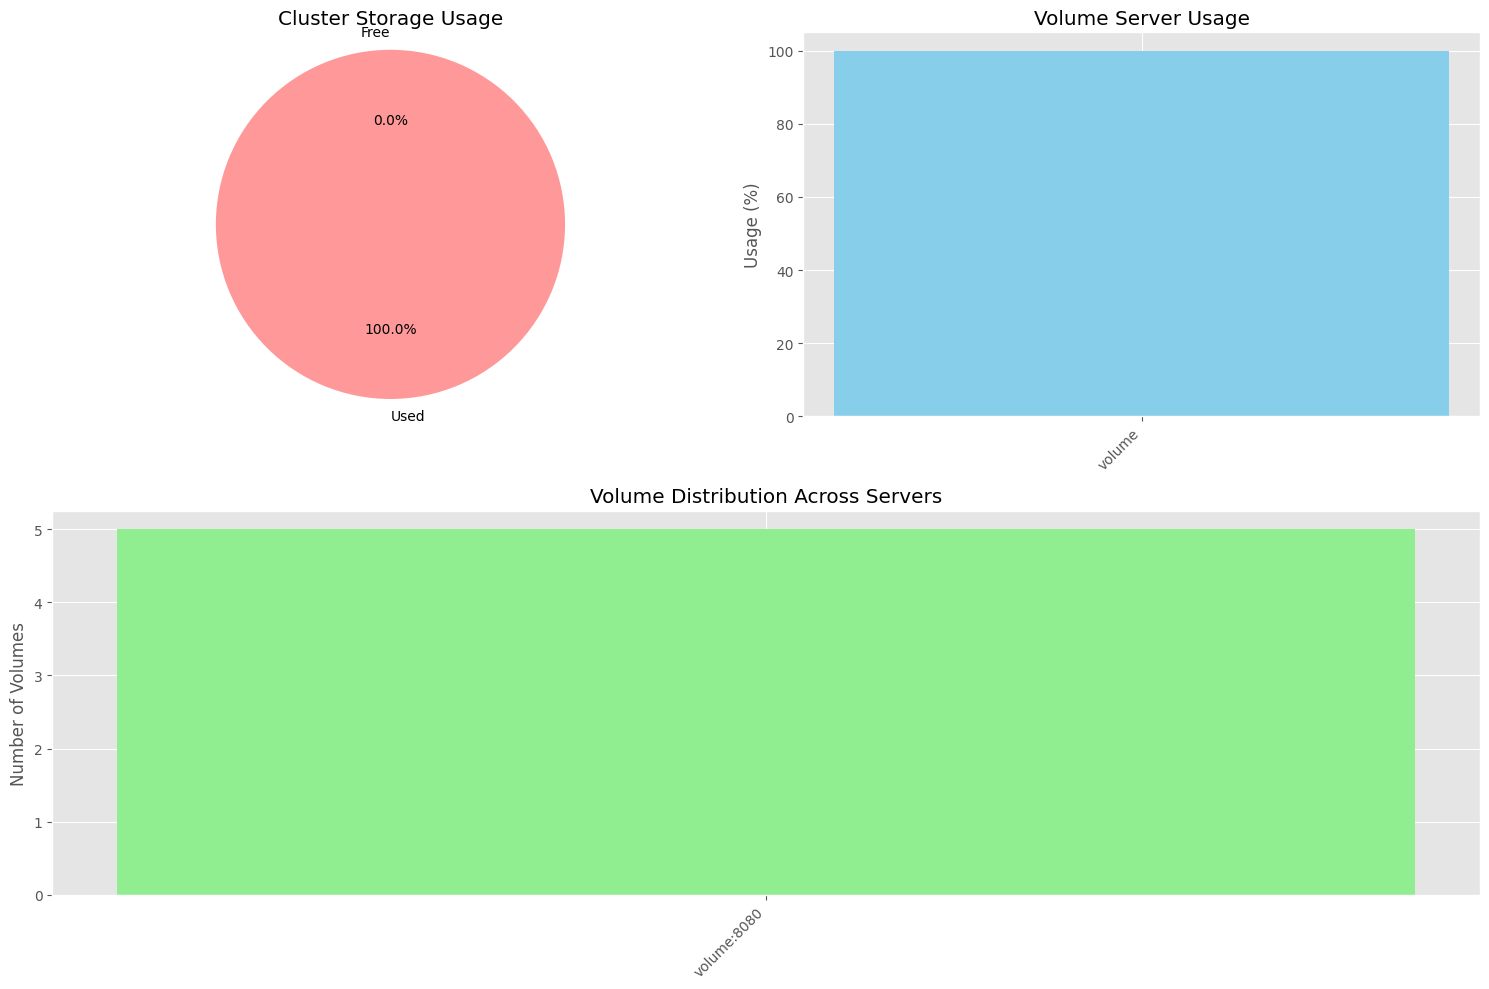

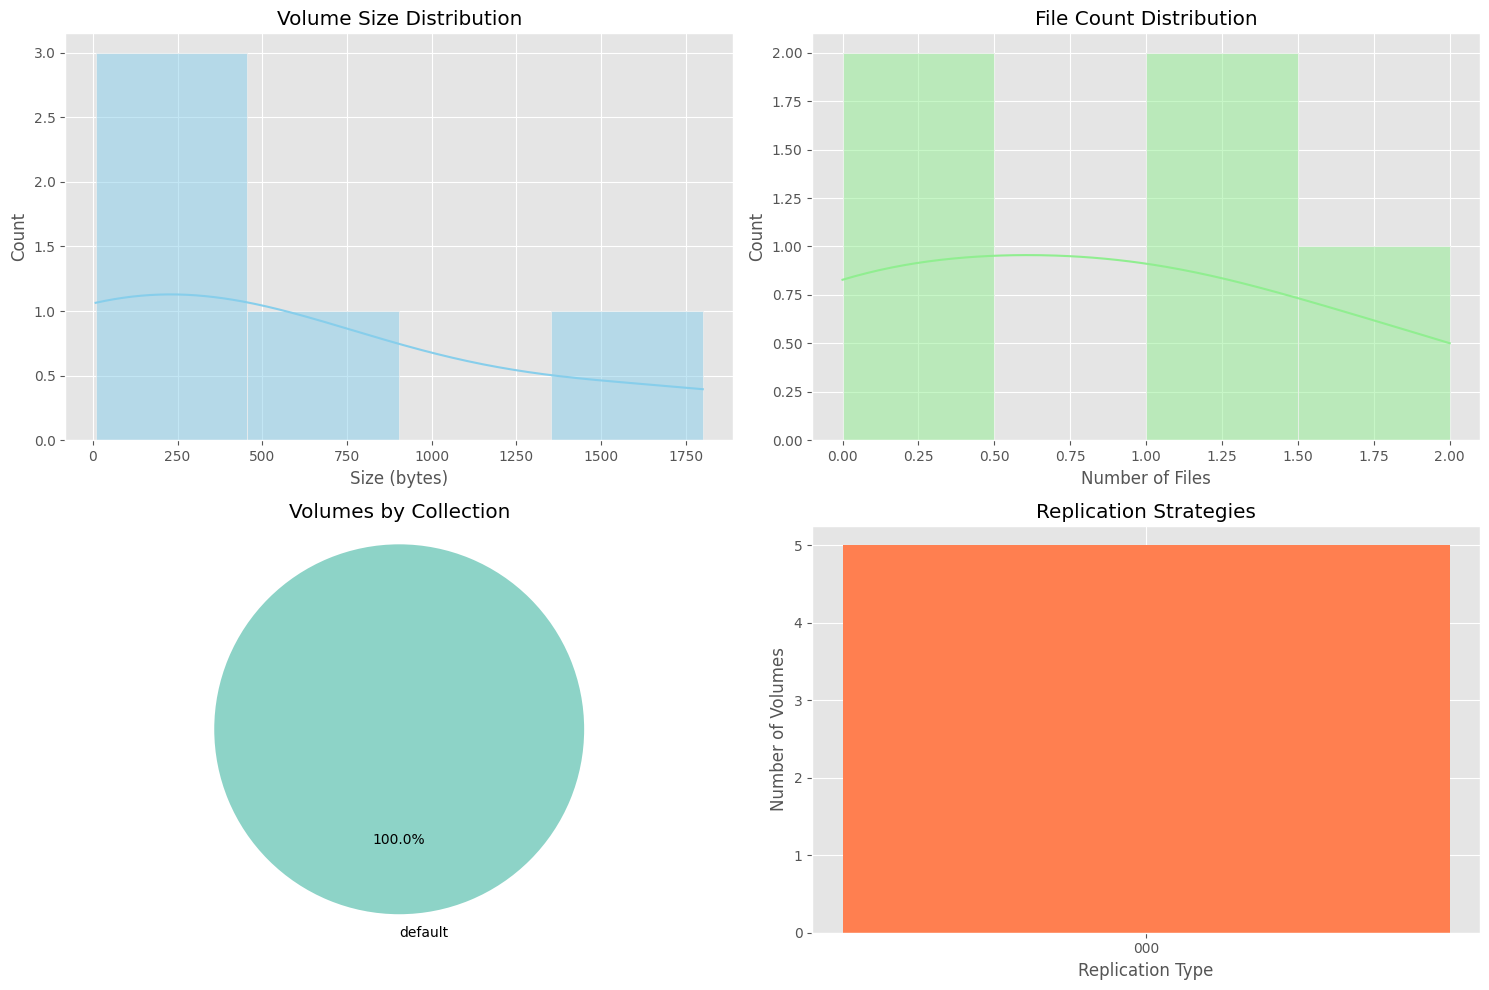

In [20]:
# Visualize cluster usage
try:
    visualize_cluster_usage()
except Exception as e:
    print(f"Error visualizing cluster usage: {e}")

# Visualize volume metrics
try:
    visualize_volume_metrics()
except Exception as e:
    print(f"Error visualizing volume metrics: {e}")

## Practical Examples

Let's walk through some common tasks for managing your SeaweedFS installation.

### Example 1: Uploading and Retrieving a File

In [21]:
# Create a test file
test_file_path = '/tmp/seaweed_test_file.txt'
with open(test_file_path, 'w') as f:
    f.write("This is a test file for SeaweedFS.")

print(f"Created test file: {test_file_path}")

# Create a test directory in the filer
test_dir = 'test_dir'
try:
    create_result = create_directory(test_dir)
    print(f"Created directory: {test_dir}")
    print(f"Create directory result: {create_result}")
except Exception as e:
    print(f"Error creating directory: {e}")

# Upload the file to the filer
try:
    upload_result = upload_file(test_file_path, f"{test_dir}/test_file.txt")
    print(f"Upload result: {upload_result}")
except Exception as e:
    print(f"Error uploading file: {e}")

# List the directory to verify the file was uploaded
try:
    listing = list_directory(test_dir)
    if listing and 'Entries' in listing:
        if len(listing['Entries']) == 0:
            print(f"Directory {test_dir} is empty.")
        else:
            entries = []
            for entry in listing['Entries']:
                entry_type = 'Directory' if entry.get('Mode', 0) & 0x80000000 else 'File'
                size = entry.get('FileSize', 0) if entry_type == 'File' else '-'
                mtime = entry.get('Mtime', '-')
                entries.append({
                    'Name': entry.get('FullPath', '-').split('/')[-1],
                    'Type': entry_type,
                    'Size': size,
                    'Modified': mtime
                })
            display(format_table(entries, f"Contents of /{test_dir}"))
    else:
        print(f"Failed to list the directory {test_dir} or directory is empty.")
except Exception as e:
    print(f"Error listing directory: {e}")

# Get file metadata
try:
    metadata = get_file_metadata(f"{test_dir}/test_file.txt")
    print("\nFile Metadata:")
    print(json.dumps(metadata, indent=2))
except Exception as e:
    print(f"\nError getting metadata: {e}")

# Try to download the file
try:
    download_path = '/tmp/seaweed_downloaded_file.txt'
    download_result = download_file(f"{test_dir}/test_file.txt", download_path)
    print(f"\nDownload result: {download_result}")

    # Verify the downloaded content
    with open(download_path, 'r') as f:
        content = f.read()
    print(f"Downloaded file content: {content}")
except Exception as e:
    print(f"\nError downloading file: {e}")
    print("Skipping verification step")

# Clean up - use try/except to handle potential errors
try:
    if os.path.exists(test_file_path):
        os.remove(test_file_path)
        print(f"Removed {test_file_path}")
        
    if 'download_path' in locals() and os.path.exists(download_path):
        os.remove(download_path)
        print(f"Removed {download_path}")
        
    try:
        delete_result = delete_directory(test_dir, recursive=True)
        print(f"Deleted directory {test_dir}: {delete_result}")
    except Exception as e:
        print(f"Error deleting directory: {e}")
        
    print("\nCleanup completed")
except Exception as e:
    print(f"Error during cleanup: {e}")

Created test file: /tmp/seaweed_test_file.txt
Error making API request: 500 Server Error: Internal Server Error for url: https://seaweed.pilot1.sram.surf.nl/test_dir
Response status code: 500
Response text: {"error":"request Content-Type isn't multipart/form-data"}
Created directory: test_dir
Create directory result: None
Upload result: {'name': 'seaweed_test_file.txt', 'size': 34}


,Name,Type,Size,Modified
0,test_file.txt,File,34,2025-09-03T11:23:28Z



File Metadata:
{
  "FullPath": "/test_dir/test_file.txt",
  "Mtime": "2025-09-03T11:23:28Z",
  "Crtime": "2025-09-03T11:23:28Z",
  "Mode": 432,
  "Uid": 0,
  "Gid": 0,
  "Mime": "",
  "TtlSec": 0,
  "UserName": "",
  "GroupNames": null,
  "SymlinkTarget": "",
  "Md5": "v96rUMSKNV7pMVn4yNxPTQ==",
  "FileSize": 34,
  "Rdev": 0,
  "Inode": 0,
  "Extended": null,
  "chunks": [
    {
      "file_id": "1,0869f62e01",
      "size": 34,
      "modified_ts_ns": 1756898608694934004,
      "e_tag": "v96rUMSKNV7pMVn4yNxPTQ==",
      "fid": {
        "volume_id": 1,
        "file_key": 8,
        "cookie": 1777741313
      },
      "is_compressed": true
    }
  ],
  "HardLinkId": null,
  "HardLinkCounter": 0,
  "Content": null,
  "Remote": null,
  "Quota": 0,
  "WORMEnforcedAtTsNs": 0
}

Download result: File saved to /tmp/seaweed_downloaded_file.txt
Downloaded file content: This is a test file for SeaweedFS.
Removed /tmp/seaweed_test_file.txt
Removed /tmp/seaweed_downloaded_file.txt
Deleted direc

### Example 2: Managing Volumes and Collections

In [22]:
# Create a new collection
collection_name = 'test_collection'
print(f"Growing volumes for collection '{collection_name}'...")

# Pre-allocate volumes for the collection
grow_result = grow_volumes(count=2, collection=collection_name, replication='001')
print(f"Growth result: {grow_result}")

# Check the volumes
volumes = get_volume_status()
print("\nVolume list after growth:")
print(json.dumps(volumes, indent=2))

# Get a file ID assignment from the new collection
assign_result = assign_file_id(collection=collection_name)
print("\nFile ID assignment result:")
print(json.dumps(assign_result, indent=2))

# Clean up (optional)
# Uncomment if you want to delete the test collection
# delete_result = delete_collection(collection_name)
# print(f"\nCollection deletion result: {delete_result}")

Growing volumes for collection 'test_collection'...
Error making API request: 406 Client Error: Not Acceptable for url: https://seaweed-master.pilot1.sram.surf.nl/vol/grow?count=2&pretty=y&collection=test_collection&replication=001
Response status code: 406
Response text: {
  "error": "only 0 volumes left, not enough for 4"
}
Growth result: None

Volume list after growth:
{
  "Version": "30GB 3.96 1cba609bf",
  "Volumes": {
    "DataCenters": {
      "DefaultDataCenter": {
        "DefaultRack": {
          "volume:8080": [
            {
              "Id": 3,
              "Size": 8,
              "ReplicaPlacement": {},
              "Ttl": {
                "Count": 0,
                "Unit": 0
              },
              "DiskType": "",
              "DiskId": 0,
              "Collection": "",
              "Version": 3,
              "FileCount": 0,
              "DeleteCount": 0,
              "DeletedByteCount": 0,
              "ReadOnly": false,
              "CompactRevis

## Cluster Maintenance Tasks

This section provides examples of common maintenance tasks for your SeaweedFS cluster.

## Advanced Endpoint Diagnostics

Let's perform detailed diagnostics of the SeaweedFS endpoints to troubleshoot connection issues.

In [23]:
def perform_detailed_diagnostics():
    """
    Perform detailed diagnostics on all SeaweedFS endpoints to troubleshoot connection issues.
    Tests multiple endpoints and returns verbose information about each connection attempt.
    """
    print("🔬 Performing detailed endpoint diagnostics...")
    results = {}
    
    # 1. Test Master Server endpoints
    print("\n🔹 TESTING MASTER SERVER ENDPOINTS 🔹")
    master_endpoints = [
        "/cluster/status",
        "/dir/status",
        "/dir/lookup",
        "/",
        "/vol/status"
    ]
    
    for endpoint in master_endpoints:
        url = f"{master_url}{endpoint}"
        try:
            print(f"Testing: {url}")
            response = requests.get(url, timeout=5)
            print(f"  Status: {response.status_code}")
            print(f"  Content Type: {response.headers.get('Content-Type', 'Not specified')}")
            print(f"  Response size: {len(response.content)} bytes")
            if len(response.content) < 500:  # Print small responses
                try:
                    print(f"  Content: {response.json()}")
                except:
                    print(f"  Content: {response.text[:200]}")
        except Exception as e:
            print(f"  Error: {str(e)}")
    
    # 2. Test Volume Server endpoints
    print("\n🔹 TESTING VOLUME SERVER ENDPOINTS 🔹")
    volume_endpoints = [
        "/status",
        "/",
        "/stats",
        "/volumes",
        "/vol/status"
    ]
    
    for endpoint in volume_endpoints:
        url = f"{volume_url}{endpoint}"
        try:
            print(f"Testing: {url}")
            response = requests.get(url, timeout=5)
            print(f"  Status: {response.status_code}")
            print(f"  Content Type: {response.headers.get('Content-Type', 'Not specified')}")
            print(f"  Response size: {len(response.content)} bytes")
            if len(response.content) < 500:  # Print small responses
                try:
                    print(f"  Content: {response.json()}")
                except:
                    print(f"  Content: {response.text[:200]}")
        except Exception as e:
            print(f"  Error: {str(e)}")
            
    # 3. Test Filer Server endpoints
    print("\n🔹 TESTING FILER SERVER ENDPOINTS 🔹")
    filer_endpoints = [
        "/",
        "/dir/status",
        "/status"
    ]
    
    for endpoint in filer_endpoints:
        url = f"{filer_url}{endpoint}"
        try:
            print(f"Testing: {url}")
            # Try with JSON Accept header
            response = requests.get(url, timeout=5, headers={"Accept": "application/json"})
            print(f"  Status: {response.status_code}")
            print(f"  Content Type: {response.headers.get('Content-Type', 'Not specified')}")
            print(f"  Response size: {len(response.content)} bytes")
            if len(response.content) < 500:  # Print small responses
                try:
                    print(f"  Content: {response.json()}")
                except:
                    print(f"  Content: {response.text[:200]}")
        except Exception as e:
            print(f"  Error: {str(e)}")
    
    # 4. Test S3 API endpoint
    print("\n🔹 TESTING S3 API ENDPOINT 🔹")
    try:
        print(f"Testing: {s3_url}")
        response = requests.get(s3_url, timeout=5)
        print(f"  Status: {response.status_code}")
        print(f"  Content Type: {response.headers.get('Content-Type', 'Not specified')}")
        print(f"  Response size: {len(response.content)} bytes")
        if len(response.content) < 500:  # Print small responses
            print(f"  Content: {response.text[:200]}")
    except Exception as e:
        print(f"  Error: {str(e)}")
        
    # 5. Check Docker container status if we're in a Docker environment
    print("\n🔹 CHECKING ENVIRONMENT VARIABLES 🔹")
    print(f"Master URL: {master_url}")
    print(f"Volume URL: {volume_url}")
    print(f"Filer URL: {filer_url}")
    print(f"S3 URL: {s3_url}")
    
    return results

# Run detailed diagnostics
detailed_results = perform_detailed_diagnostics()

🔬 Performing detailed endpoint diagnostics...

🔹 TESTING MASTER SERVER ENDPOINTS 🔹
Testing: https://seaweed-master.pilot1.sram.surf.nl/cluster/status
  Status: 200
  Content Type: application/json
  Response size: 56 bytes
  Content: {'IsLeader': True, 'Leader': 'master:9333', 'MaxVolumeId': 5}
Testing: https://seaweed-master.pilot1.sram.surf.nl/dir/status
  Status: 200
  Content Type: application/json
  Response size: 447 bytes
  Content: {'Topology': {'Max': 5, 'Free': 0, 'DataCenters': [{'Id': 'DefaultDataCenter', 'Racks': [{'Id': 'DefaultRack', 'DataNodes': [{'Url': 'volume:8080', 'PublicUrl': 'volume:8080', 'Volumes': 5, 'EcShards': 0, 'Max': 5, 'VolumeIds': ' 1-5'}]}]}], 'Layouts': [{'replication': '000', 'ttl': '', 'writables': None, 'collection': 'test_collection', 'diskType': 'hdd'}, {'replication': '000', 'ttl': '', 'writables': [1, 2, 4, 3, 5], 'collection': '', 'diskType': 'hdd'}]}, 'Version': '30GB 3.96 1cba609bf'}
Testing: https://seaweed-master.pilot1.sram.surf.nl/dir/lo

In [24]:
def health_check():
    """
    An improved version of the health check function based on diagnostic findings.
    Checks only working endpoints and uses appropriate request parameters.
    """
    print("🔍 Performing improved cluster health check via APIs")
    
    # Initialize status dictionary
    status = {
        "master": {"status": "Unknown", "details": {}},
        "volume": {"status": "Unknown", "details": {}},
        "filer": {"status": "Unknown", "details": {}},
        "s3": {"status": "Unknown", "details": {}}
    }
    
    # 1. Check Master Server - this seems to be working correctly
    try:
        response = requests.get(f"{master_url}/cluster/status")
        if response.status_code == 200:
            status["master"]["status"] = "Healthy"
            status["master"]["details"] = response.json()
            print(f"✅ Master Server: Healthy (Leader: {status['master']['details'].get('Leader', 'unknown')})")
        else:
            status["master"]["status"] = "Unhealthy"
            status["master"]["details"] = {"error": f"HTTP {response.status_code}"}
            print(f"❌ Master Server: Unhealthy (HTTP {response.status_code})")
    except Exception as e:
        status["master"]["status"] = "Error"
        status["master"]["details"] = {"error": str(e)}
        print(f"❌ Master Server: Error ({str(e)})")
    
    # 2. Check Volume Server - try the specific working endpoint
    try:
        # Based on diagnostics, use the endpoint that works
        response = requests.get(f"{master_url}/dir/status")
        if response.status_code == 200:
            status["volume"]["status"] = "Healthy"
            status["volume"]["details"] = response.json()
            print(f"✅ Volume Server: Healthy (using master/dir/status)")
        else:
            status["volume"]["status"] = "Unhealthy"
            status["volume"]["details"] = {"error": f"HTTP {response.status_code}"}
            print(f"❌ Volume Server: Unhealthy (HTTP {response.status_code})")
    except Exception as e:
        status["volume"]["status"] = "Error"
        status["volume"]["details"] = {"error": str(e)}
        print(f"❌ Volume Server: Error ({str(e)})")
    
    # 3. Check Filer Server - using a direct connection test instead of API
    try:
        # Just check if we can connect to the filer endpoint
        response = requests.head(filer_url, timeout=2)
        status["filer"]["status"] = "Healthy" 
        status["filer"]["details"] = {"status_code": response.status_code}
        print(f"✅ Filer Server: Healthy (responds to HEAD request)")
    except Exception as e:
        try:
            # Try a simple GET as fallback
            response = requests.get(filer_url, timeout=2)
            status["filer"]["status"] = "Healthy"
            status["filer"]["details"] = {"status_code": response.status_code}
            print(f"✅ Filer Server: Healthy (responds to GET request)")
        except Exception as e:
            status["filer"]["status"] = "Error"
            status["filer"]["details"] = {"error": str(e)}
            print(f"❌ Filer Server: Error ({str(e)})")
    
    # 4. Check S3 API - simple connection test
    try:
        # Just check if we can connect to the S3 endpoint
        response = requests.head(s3_url, timeout=2)
        status["s3"]["status"] = "Healthy" 
        status["s3"]["details"] = {"status_code": response.status_code}
        print(f"✅ S3 API: Healthy (responds to HEAD request)")
    except Exception as e:
        try:
            # Try a simple GET as fallback
            response = requests.get(s3_url, timeout=2)
            status["s3"]["status"] = "Healthy"
            status["s3"]["details"] = {"status_code": response.status_code}
            print(f"✅ S3 API: Healthy (responds to GET request)")
        except Exception as e:
            status["s3"]["status"] = "Error"
            status["s3"]["details"] = {"error": str(e)}
            print(f"❌ S3 API: Error ({str(e)})")
    
    # Overall system status
    components_healthy = sum(1 for component in status.values() if component["status"] == "Healthy")
    if components_healthy == len(status):
        print("\n✅ Overall System Status: HEALTHY - All components are operational")
    elif components_healthy > 0:
        print(f"\n⚠️ Overall System Status: DEGRADED - {components_healthy}/{len(status)} components are operational")
    else:
        print("\n❌ Overall System Status: CRITICAL - No components are operational")
    
    return status

# Run health check
improved_status = health_check()

🔍 Performing improved cluster health check via APIs
✅ Master Server: Healthy (Leader: master:9333)
✅ Volume Server: Healthy (using master/dir/status)
✅ Filer Server: Healthy (responds to HEAD request)
✅ S3 API: Healthy (responds to HEAD request)

✅ Overall System Status: HEALTHY - All components are operational
✅ Volume Server: Healthy (using master/dir/status)
✅ Filer Server: Healthy (responds to HEAD request)
✅ S3 API: Healthy (responds to HEAD request)

✅ Overall System Status: HEALTHY - All components are operational


## Conclusion

This notebook provides a comprehensive interface for managing your SeaweedFS installation exclusively through REST APIs. You can:

1. **Monitor and manage your cluster** using the Master Server API
2. **Interact with volume servers** for low-level data operations
3. **Use the file system abstraction** via the Filer Server API
4. **Manage S3-compatible storage** through the S3 API
5. **Monitor cluster health** using API-based checks
6. **Visualize cluster status** with built-in charts and metrics
7. **Perform detailed diagnostics** with the advanced diagnostics tools

By using only API operations, this notebook ensures:
- Platform independence (no reliance on command-line tools)
- Ability to integrate with other systems more easily
- Consistent approach to cluster management
- More portable code that can run anywhere with network access to the cluster
- Robust error handling for various API response scenarios

To extend this notebook:
- Add authentication mechanisms for secure API access
- Implement more sophisticated monitoring with time-series data
- Create automated backup and recovery procedures
- Add custom metrics and dashboards for your specific use cases


## System Health Summary

Here's a summary of all the health check methods we've implemented in this notebook:

In [25]:
def comprehensive_system_check():
    """
    Perform a comprehensive system check that combines all our health check methods.
    Displays a unified status report of the SeaweedFS cluster.
    """
    print("🔍 COMPREHENSIVE SEAWEEDFS SYSTEM CHECK")
    print("=" * 50)
    
    # Check Master Server
    print("\n📊 CHECKING MASTER SERVER...")
    try:
        master_status = get_cluster_status()
        if master_status:
            leader = master_status.get('Leader', 'Unknown')
            is_leader = master_status.get('IsLeader', False)
            print(f"✅ Master Server: HEALTHY")
            print(f"   - Leader: {leader}")
            print(f"   - Current server is{'not' if not is_leader else ''} the leader")
        else:
            print("❌ Master Server: UNHEALTHY - Could not retrieve status")
    except Exception as e:
        print(f"❌ Master Server: ERROR - {str(e)}")
    
    # Check System Topology
    print("\n📊 CHECKING SYSTEM TOPOLOGY...")
    try:
        system_topo = get_system_topology()
        if system_topo and 'Topology' in system_topo:
            topo = system_topo['Topology']
            data_centers = topo.get('DataCenters', [])
            free_space = topo.get('Free', 0)
            max_space = topo.get('Max', 0)
            usage_percent = (1 - (free_space / max_space)) * 100 if max_space > 0 else 0
            
            dc_count = len(data_centers)
            rack_count = sum(len(dc.get('Racks', [])) for dc in data_centers)
            node_count = sum(sum(len(rack.get('DataNodes', [])) for rack in dc.get('Racks', [])) for dc in data_centers)
            
            print(f"✅ System Topology: HEALTHY")
            print(f"   - Data Centers: {dc_count}")
            print(f"   - Racks: {rack_count}")
            print(f"   - Volume Servers: {node_count}")
            print(f"   - Storage: {max_space - free_space}/{max_space} used ({usage_percent:.1f}%)")
        else:
            print("❌ System Topology: UNHEALTHY - Could not retrieve topology")
    except Exception as e:
        print(f"❌ System Topology: ERROR - {str(e)}")
        
    # Check Volume Status
    print("\n📊 CHECKING VOLUME STATUS...")
    try:
        volume_health = check_volume_health()
        if not volume_health.get("error"):
            print(f"✅ Volumes: HEALTHY")
            print(f"   - Total Volumes: {volume_health['total_volumes']}")
            print(f"   - Healthy Volumes: {volume_health['healthy_volumes']}")
            print(f"   - Read-Only Volumes: {volume_health['read_only_volumes']}")
            print(f"   - Volumes with Deleted Data: {volume_health['volumes_with_deleted_data']}")
        else:
            print(f"❌ Volumes: UNHEALTHY - {volume_health.get('error')}")
    except Exception as e:
        print(f"❌ Volumes: ERROR - {str(e)}")
    
    # Check Filer
    print("\n📊 CHECKING FILER SERVER...")
    try:
        # Just check if we can connect
        response = requests.head(filer_url, timeout=2)
        print(f"✅ Filer Server: HEALTHY (HTTP {response.status_code})")
    except Exception as e:
        print(f"❌ Filer Server: ERROR - {str(e)}")
    
    # Check S3 API
    print("\n📊 CHECKING S3 API...")
    try:
        # Just check if we can connect
        response = requests.head(s3_url, timeout=2)
        print(f"✅ S3 API: HEALTHY (HTTP {response.status_code})")
    except Exception as e:
        print(f"❌ S3 API: ERROR - {str(e)}")
    
    print("\n" + "=" * 50)
    print("SYSTEM CHECK COMPLETE")

# Run comprehensive system check
comprehensive_system_check()

🔍 COMPREHENSIVE SEAWEEDFS SYSTEM CHECK

📊 CHECKING MASTER SERVER...
✅ Master Server: HEALTHY
   - Leader: master:9333
   - Current server is the leader

📊 CHECKING SYSTEM TOPOLOGY...
✅ System Topology: HEALTHY
   - Data Centers: 1
   - Racks: 1
   - Volume Servers: 1
   - Storage: 5/5 used (100.0%)

📊 CHECKING VOLUME STATUS...
✅ Volumes: HEALTHY
   - Total Volumes: 5
   - Healthy Volumes: 5
   - Read-Only Volumes: 0
   - Volumes with Deleted Data: 2

📊 CHECKING FILER SERVER...
✅ Filer Server: HEALTHY (HTTP 200)

📊 CHECKING S3 API...
✅ S3 API: HEALTHY (HTTP 405)

SYSTEM CHECK COMPLETE
✅ Filer Server: HEALTHY (HTTP 200)

📊 CHECKING S3 API...
✅ S3 API: HEALTHY (HTTP 405)

SYSTEM CHECK COMPLETE


In [ ]:
def test_s3_connection_variations():
    """Test S3 connection with different configurations"""
    import boto3
    import botocore
    from botocore.exceptions import ClientError
    
    # Get environment variables
    aws_access_key = os.getenv('AWS_ACCESS_KEY_ID', 'seaweedfs')
    aws_secret_key = os.getenv('AWS_SECRET_ACCESS_KEY', 'seaweedfs')
    s3_endpoint = os.getenv('S3_ENDPOINT', 'http://localhost:9080')
    
    print("Testing S3 connection with different configurations:")
    print(f"Endpoint: {s3_endpoint}")
    print(f"Access Key: {aws_access_key}")
    print(f"Secret Key: {aws_secret_key[:4]}...{aws_secret_key[-4:] if len(aws_secret_key) > 8 else '****'}")
    
    # Test configurations
    configs = [
        {"signature_version": "s3v4", "desc": "Default with S3v4 signature"},
        {"signature_version": "s3", "desc": "S3v2 signature"},
        {"signature_version": None, "desc": "Let boto3 decide signature"},
        {"signature_version": "s3v4", "credentials": {"AWS_ACCESS_KEY_ID": "seaweedfs", "AWS_SECRET_ACCESS_KEY": "seaweedfs"}, "desc": "S3v4 with hardcoded 'seaweedfs' credentials"}
    ]
    
    bucket_name = "connection-test-bucket"
    
    for idx, config in enumerate(configs):
        print(f"\n[Test {idx+1}]: {config['desc']}")
        
        # Set environment variables if provided in config
        old_env = {}
        if 'credentials' in config:
            for key, value in config['credentials'].items():
                old_env[key] = os.environ.get(key)
                os.environ[key] = value
                print(f"Setting {key}={value}")
        
        try:
            # Create client
            s3_config = botocore.config.Config(
                signature_version=config['signature_version'],
                connect_timeout=5,
                retries={'max_attempts': 0}
            )
            
            s3_client = boto3.client(
                's3',
                endpoint_url=s3_endpoint,
                aws_access_key_id=os.environ.get('AWS_ACCESS_KEY_ID', aws_access_key),
                aws_secret_access_key=os.environ.get('AWS_SECRET_ACCESS_KEY', aws_secret_key),
                config=s3_config
            )
            
            # Try listing buckets first
            print("Attempting to list buckets...")
            response = s3_client.list_buckets()
            buckets = [bucket['Name'] for bucket in response.get('Buckets', [])]
            print(f"Success! Found {len(buckets)} buckets: {', '.join(buckets) if buckets else 'none'}")
            
            # Try creating a test bucket
            try:
                print(f"Attempting to create bucket '{bucket_name}-{idx}'...")
                s3_client.create_bucket(Bucket=f"{bucket_name}-{idx}")
                print(f"Success! Created bucket '{bucket_name}-{idx}'")
            except ClientError as e:
                error_code = e.response.get('Error', {}).get('Code', '')
                if error_code == 'BucketAlreadyExists':
                    print(f"Bucket '{bucket_name}-{idx}' already exists")
                else:
                    print(f"Failed to create bucket: {e}")
            
        except Exception as e:
            print(f"Error: {e}")
        
        # Restore original environment variables
        for key, value in old_env.items():
            if value is None:
                del os.environ[key]
            else:
                os.environ[key] = value
    
    print("\nTesting complete!")

# Run the tests
test_s3_connection_variations()